In [1]:
import json

# Read the mp_data.jsonl file
with open('mp_data.jsonl', 'r') as file:
    data = [json.loads(line) for line in file]
# Extract values where label == 'test'
test_data = [item for item in data if item.get('label') == 'test']

In [3]:
print(len(test_data))
print(test_data[0]['symmetry']['crystal_system'].lower())

522
{'elements': ['B', 'Fe'], 'formula_pretty': 'FeB', 'symmetry': {'crystal_system': 'Orthorhombic', 'symbol': 'Cmcm', 'number': 63, 'point_group': 'mmm', 'symprec': 0.1}, 'primitive_structure': {'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0.0, 'lattice': {'matrix': [[1.448887, -3.770052, 0.0], [1.448887, 3.770052, 0.0], [0.0, 0.0, 2.94631]], 'pbc': [True, True, True], 'a': 4.038881, 'b': 4.038881, 'c': 2.94631, 'alpha': 90.0, 'beta': 90.0, 'gamma': 137.95498, 'volume': 32.187721}, 'properties': {}, 'sites': [{'species': [{'element': 'Fe', 'occu': 1}], 'abc': [0.856822, 0.143178, 0.75], 'xyz': [1.448887, -2.690477, 2.209733], 'properties': {'magmom': 1.494}, 'label': 'Fe'}, {'species': [{'element': 'Fe', 'occu': 1}], 'abc': [0.143178, 0.856822, 0.25], 'xyz': [1.448887, 2.690477, 0.736578], 'properties': {'magmom': 1.494}, 'label': 'Fe'}, {'species': [{'element': 'B', 'occu': 1}], 'abc': [0.569059, 0.430941, 0.75], 'xyz': [1.448887, -0.520714, 2.209733], 'pro

In [3]:
# Read the generated_predictions.jsonl file
with open('../ElaTBoT-DFT/ft_result/prompt4/test_result_repeat_in_bohrium_v100/generated_predictions.jsonl', 'r') as file:
    generated_test_data = [json.loads(line) for line in file]
# Print the number of generated predictions
print(len(generated_test_data))

522


In [4]:
#check the sequence with prompt type data
import ast
with open("../reproduce/data/prompt_type_1/ec_short_test_dataset.json", 'r') as file:
    prompt1_data = json.load(file)
et_seq = [data['elastic_tensor'] for data in test_data]
prompt1_seq = [ast.literal_eval(prompt1_data[i]['output']) for i in range(len(prompt1_data))]
print(len(prompt1_seq))
print(len(et_seq))
if len(et_seq) != len(prompt1_seq):
    print("Length mismatch between test data and generated predictions.")
seq_right = True
for i in range(len(prompt1_seq)):
    if prompt1_seq[i] != et_seq[i]:
        seq_right = False
        print(f"Mismatch at index {i}: {prompt1_seq[i]} != {et_seq[i]}")
        break
if seq_right:
    print("All sequences match.")

522
522
All sequences match.


In [5]:
import numpy as np

def check_elastic_constants_symmetry(crystal_system, C, tolerance=2.0):
    if not isinstance(C, np.ndarray) or C.shape != (6, 6):
        raise ValueError("Elastic constants matrix must be a 6x6 numpy array.")
    
    crystal_system = crystal_system.lower()
    
    def is_close(val1, val2, tol=tolerance):
        return np.abs(val1 - val2) <= tol
    
    if crystal_system == "triclinic":
        # Triclinic: No symmetry constraints
        return True
    
    elif crystal_system == "monoclinic":
        # Monoclinic: C14 = C15 = C24 = C25 = C34 = C35 = C46 = C56 = 0
        if (C[0, 3] == 0 and C[0, 4] == 0 and C[1, 3] == 0 and
                C[1, 4] == 0 and C[2, 3] == 0 and C[2, 4] == 0 and
                C[3, 5] == 0 and C[4, 5] == 0):
            return True
        elif (C[0, 3] == 0 and C[0, 5] == 0 and C[1, 3] == 0 and
                C[1, 5] == 0 and C[2, 3] == 0 and C[2, 5] == 0 and
                C[3, 4] == 0 and C[4, 5] == 0):
            return True
        else:
            return [crystal_system, C]
    
    elif crystal_system == "orthorhombic":
        # Orthorhombic: monoclinic + C16 = C26 = C45 = 0
        if (C[0, 3] == 0 and C[0, 4] == 0 and C[1, 3] == 0 and
                C[1, 4] == 0 and C[2, 3] == 0 and C[2, 4] == 0 and
                C[3, 5] == 0 and C[4, 5] == 0 and C[0, 5] == 0 and
                C[1, 5] == 0 and C[2, 5] == 0 and C[3, 4] == 0):
            return True
        else:
            return [crystal_system, C]
    
    elif crystal_system == "tetragonal":
        # Tetragonal: orthorhombic + C11 = C22, C13 = C23, C44 = C55
        if (    C[0, 3] == 0 and C[0, 4] == 0 and C[1, 3] == 0 and
                C[1, 4] == 0 and C[2, 3] == 0 and C[2, 4] == 0 and
                C[3, 5] == 0 and C[4, 5] == 0 and C[0, 5] == 0 and
                C[1, 5] == 0 and C[2, 5] == 0 and C[3, 4] == 0 and
                is_close(C[0, 0], C[1, 1]) and is_close(C[0, 2], C[1, 2]) and is_close(C[3, 3], C[4, 4])):
            return True
        elif (  C[0, 3] == 0 and C[0, 4] == 0 and C[1, 3] == 0 and
                C[1, 4] == 0 and C[2, 3] == 0 and C[2, 4] == 0 and
                C[3, 5] == 0 and C[4, 5] == 0 and C[2, 5] == 0 and C[3, 4] == 0 and
                is_close(C[0, 5], -C[1, 5]) and
                is_close(C[0, 0], C[1, 1]) and is_close(C[0, 2], C[1, 2]) and is_close(C[3, 3], C[4, 4])):
            return True
        else:
            return [crystal_system, C]
                
    
    elif crystal_system == "trigonal":
        # Trigonal: orthorhombic + C11 = C22, C13 = C23, C44 = C55, C15 = -C25, C25 = C46, C66 = (C11 - C12)/2
        if (    C[2, 3] == 0 and C[2, 4] == 0 and C[0, 5] == 0 and
                C[1, 5] == 0 and C[2, 5] == 0 and C[3, 4] == 0 and
                is_close(C[0, 0], C[1, 1]) and is_close(C[0, 2], C[1, 2]) and is_close(C[3, 3], C[4, 4]) and
                is_close(np.abs(C[0, 4]), np.abs(C[1, 4])) and is_close(np.abs(C[1, 4]), np.abs(C[3, 5])) and is_close(C[5, 5], (C[0, 0] - C[0, 1]) / 2) and
                is_close(np.abs(C[0, 3]), np.abs(C[1, 3])) and is_close(np.abs(C[0, 3]), np.abs(C[4, 5]))):
            return True
        elif (  C[0, 4] == 0 and C[0, 5] == 0 and C[1, 4] == 0 and 
                C[1, 5] == 0 and C[2, 3] == 0 and C[2, 4] == 0 and
                C[2, 5] == 0 and C[3, 4] == 0 and C[3, 5] == 0 and
                is_close(C[0, 0], C[1, 1]) and is_close(C[0, 2], C[1, 2]) and is_close(C[3, 3], C[4, 4]) and
                is_close(C[5, 5], (C[0, 0] - C[0, 1]) / 2) and
                is_close(np.abs(C[0, 3]), np.abs(C[1, 3])) and is_close(np.abs(C[0, 3]), np.abs(C[4, 5]))):
            return True
        else:
            return [crystal_system, C]
    
    elif crystal_system == "hexagonal":
        # Hexagonal: orthorhombic + C11 = C22, C13 = C23, C44 = C55, C66 = C66 = (C11 - C12)/2
        if (C[0, 3] == 0 and C[0, 4] == 0 and C[1, 3] == 0 and
                C[1, 4] == 0 and C[2, 3] == 0 and C[2, 4] == 0 and
                C[3, 5] == 0 and C[4, 5] == 0 and C[0, 5] == 0 and
                C[1, 5] == 0 and C[2, 5] == 0 and C[3, 4] == 0 and
                is_close(C[0, 0], C[1, 1]) and is_close(C[0, 2], C[1, 2]) and is_close(C[3, 3], C[4, 4]) and
                is_close(C[5, 5], (C[0, 0] - C[0, 1]) / 2)):
            return True
        else:
            return [crystal_system, C]
    
    elif crystal_system == "cubic":
        # Cubic: orthorhombic + C11 = C22 = C33, C12 = C13 = C23, C44 = C55 = C66
        if (C[0, 3] == 0 and C[0, 4] == 0 and C[1, 3] == 0 and
                C[1, 4] == 0 and C[2, 3] == 0 and C[2, 4] == 0 and
                C[3, 5] == 0 and C[4, 5] == 0 and C[0, 5] == 0 and
                C[1, 5] == 0 and C[2, 5] == 0 and C[3, 4] == 0 and
                is_close(C[0, 0], C[1, 1]) and is_close(C[0, 0], C[2, 2]) and
                is_close(C[0, 1], C[0, 2]) and is_close(C[0, 1], C[1, 2]) and
                is_close(C[3, 3], C[4, 4]) and is_close(C[3, 3], C[5, 5])):
            return True
        else:
            return [crystal_system, C]
    
    else:
        raise ValueError(f"Unknown crystal system: {crystal_system}")

# Example usage
C = np.array([[328., 129.,  88.,  -3.,  -0.,   0.],
       [129., 328.,  88.,   3.,   0.,   0.],
       [ 88.,  88., 329.,   0.,   0.,   0.],
       [ -3.,   3.,   0.,  51.,   0.,   0.],
       [ -0.,   0.,   0.,   0.,  51.,  -3.],
       [  0.,   0.,   0.,   0.,  -3.,  99.]])
print(check_elastic_constants_symmetry("trigonal", C))  # Example output: True

True


In [5]:
real_data_checklist = [check_elastic_constants_symmetry(test_data[i]['symmetry']['crystal_system'], np.array(test_data[i]['elastic_tensor'])) for i in range(len(test_data))]
print(real_data_checklist.count(True))

505


In [6]:
import ast
tensor_list = [ast.literal_eval(generated_test_data[i]['predict']) for i in range(len(generated_test_data))]

In [7]:
print(len(tensor_list))

522


In [8]:
check_list = [check_elastic_constants_symmetry(test_data[i]['symmetry']['crystal_system'], np.array(tensor_list[i])) for i in range(len(tensor_list))]

In [9]:
print(check_list.count(True))

475


In [10]:
print('percentage of correct predictions:', round(check_list.count(True)/505, 2))

percentage of correct predictions: 0.94


In [21]:
rf_test_data = np.load('../ElaTBoT-DFT/algorithm_comparison/random_forest/rf_elastic_tensors_predicted_test_set.npy')
print(len(rf_test_data))

522


In [19]:
#check the sequence with prompt type data
import ast
rf_seq_data = np.load('../ElaTBoT-DFT/algorithm_comparison/random_forest/rf_elastic_tensors_real_test_set.npy')
rf_seq_data = [rf_seq_data[i].tolist() for i in range(len(rf_seq_data))]
et_seq = [data['elastic_tensor'] for data in test_data]
print(len(rf_seq_data))
print(len(et_seq))
if len(et_seq) != len(rf_seq_data):
    print("Length mismatch between test data and generated predictions.")
seq_right = True
for i in range(len(rf_seq_data)):
    if rf_seq_data[i] != et_seq[i]:
        seq_right = False
        print(f"Mismatch at index {i}: {rf_seq_data[i]} != {et_seq[i]}")
        break
if seq_right:
    print("All sequences match.")

522
522
All sequences match.


In [22]:
rf_check_list = [check_elastic_constants_symmetry(test_data[i]['symmetry']['crystal_system'], np.array(rf_test_data[i])) for i in range(len(rf_test_data))]

In [23]:
print(rf_check_list.count(True))

29


In [33]:
print('percentage of correct predictions:', round(rf_check_list.count(True)/505,2))

percentage of correct predictions: 0.06


In [25]:
from pymatgen.analysis.elasticity import ElasticTensor
matten_predict = np.load("../ElaTBoT-DFT/algorithm_comparison/MatTen_result/elastic_tensors_predicted_test_set.npy")
matten_real = np.load("../ElaTBoT-DFT/algorithm_comparison/MatTen_result/elastic_tensors_real_test_set.npy")
matten_real = [ElasticTensor(i).voigt for i in matten_real]
matten_predict = [ElasticTensor(i).voigt for i in matten_predict]

In [26]:
matten_test_data = []
for i in range(len(matten_real)):
    for j in range(len(test_data)):
        if np.allclose(np.array(matten_real[i]), np.array(test_data[j]['elastic_tensor'])):
            matten_test_data.append([test_data[j]['symmetry']['crystal_system'], matten_real[i]])

In [27]:
real_matten_data_checklist = [check_elastic_constants_symmetry(matten_test_data[i][0], np.array(matten_test_data[i][1])) for i in range(len(matten_test_data))]
print(real_matten_data_checklist.count(True))

504


In [28]:
matten_check_list = [check_elastic_constants_symmetry(matten_test_data[i][0], np.array(matten_predict[i])) for i in range(len(matten_predict))]

In [29]:
print(matten_check_list.count(True))

23


In [30]:
print('percentage of correct predictions:', round(matten_check_list.count(True)/504, 2))

percentage of correct predictions: 0.05


In [31]:
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scienceplots
plt.style.use('ieee')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

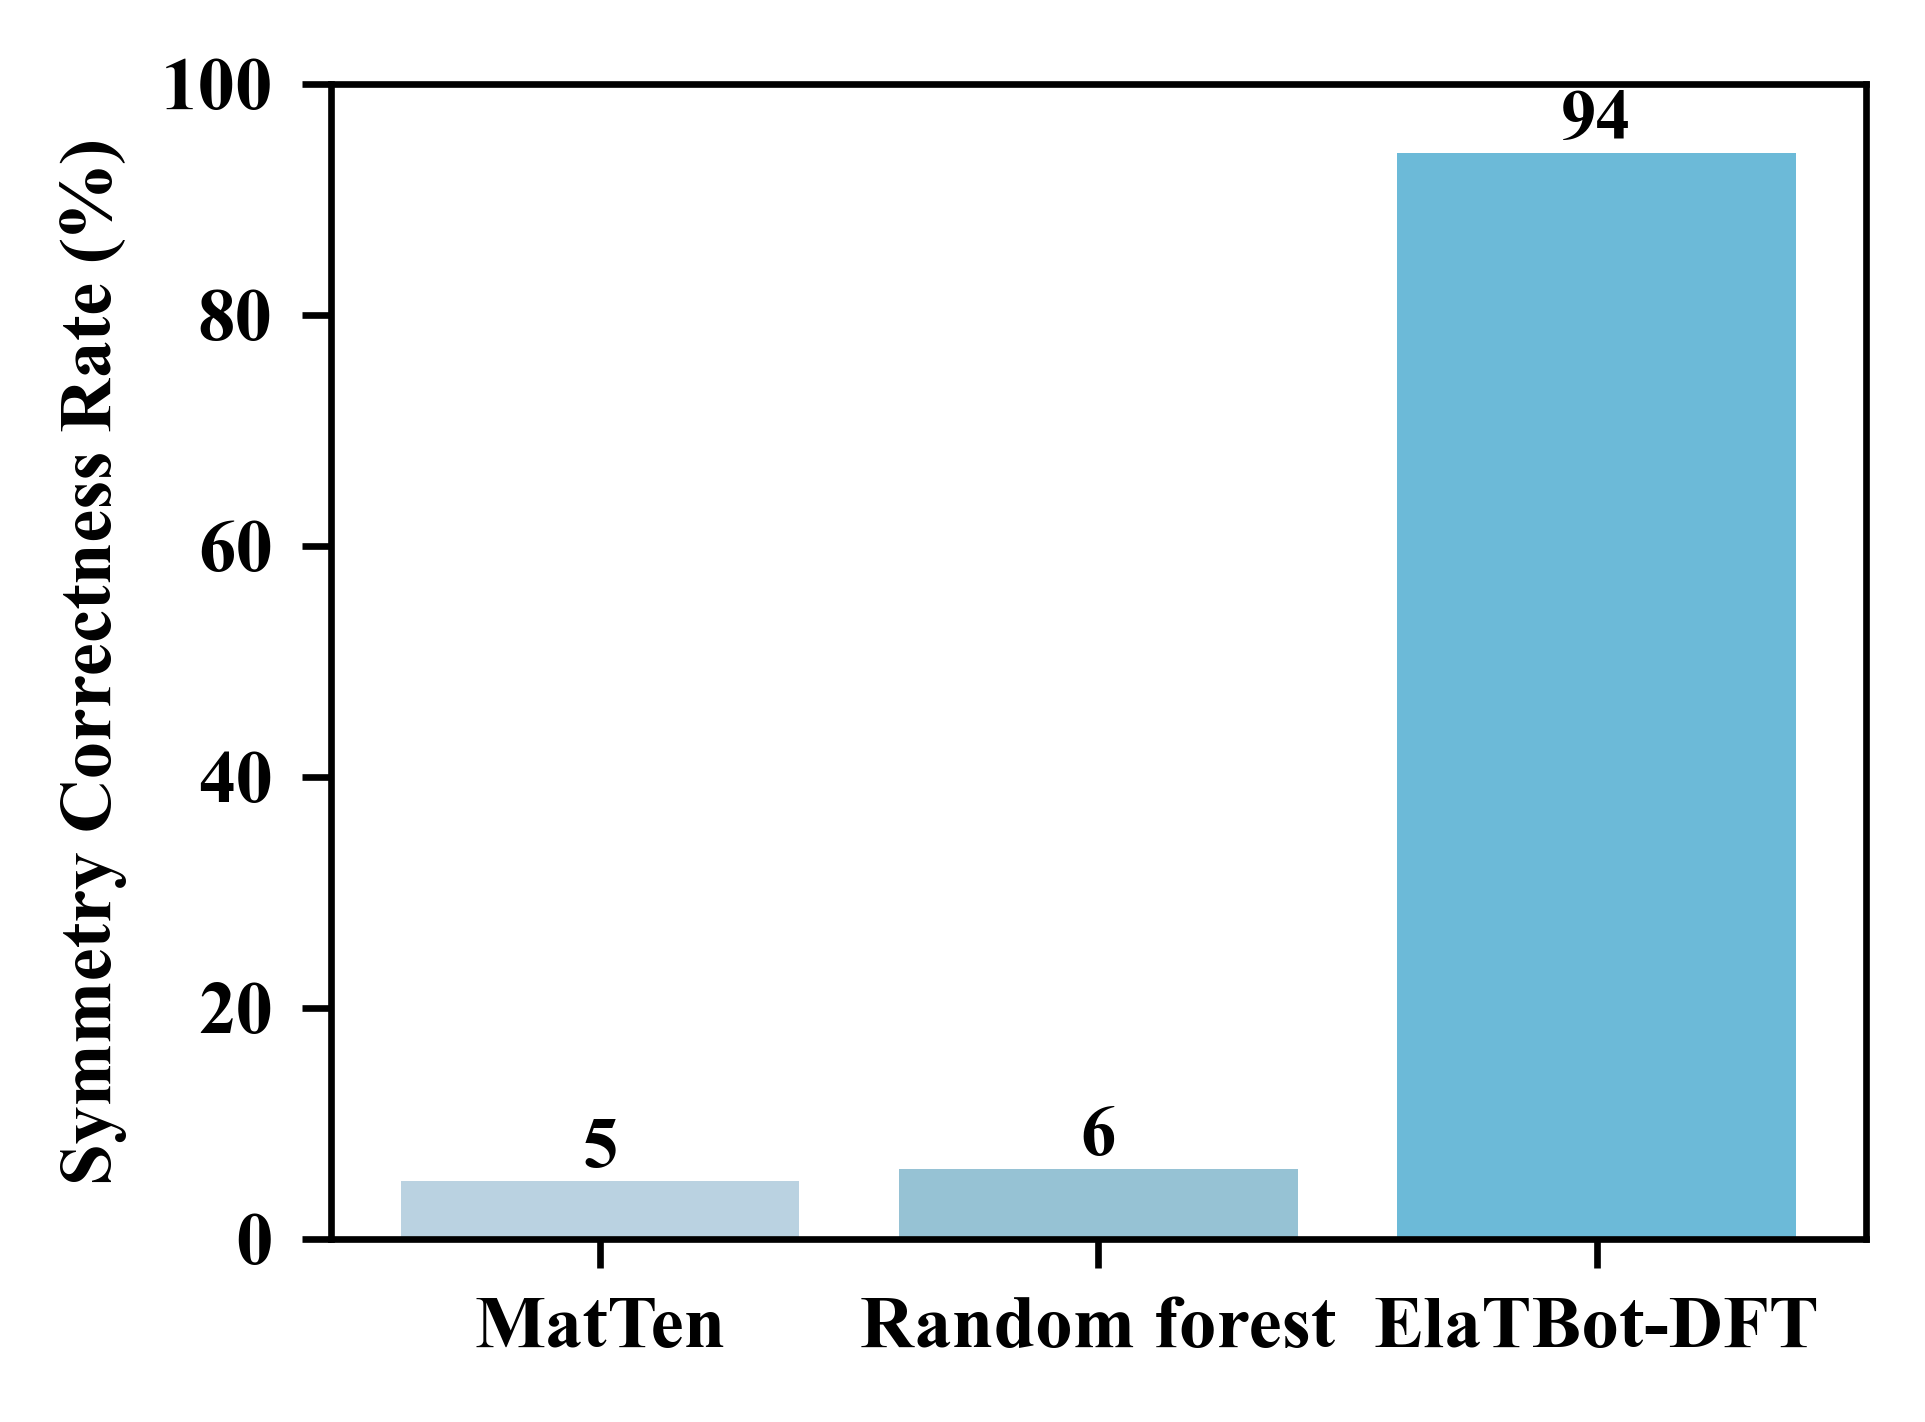

In [34]:
label = ['MatTen', 'Random forest', 'ElaTBot-DFT']
accuracy = [5, 6, 94]
bars = plt.bar(label, accuracy, color=['#BAD2E1', '#96C2D4', '#6CBAD8'])
plt.ylabel('Symmetry Correctness Rate (%)', fontsize=9)
plt.ylim(0, 100)

# Adding the accuracy values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=8.5)
plt.tick_params(axis='both', labelsize=9)
plt.savefig("symmetry_check_result.pdf", dpi=600, bbox_inches='tight')
plt.show()

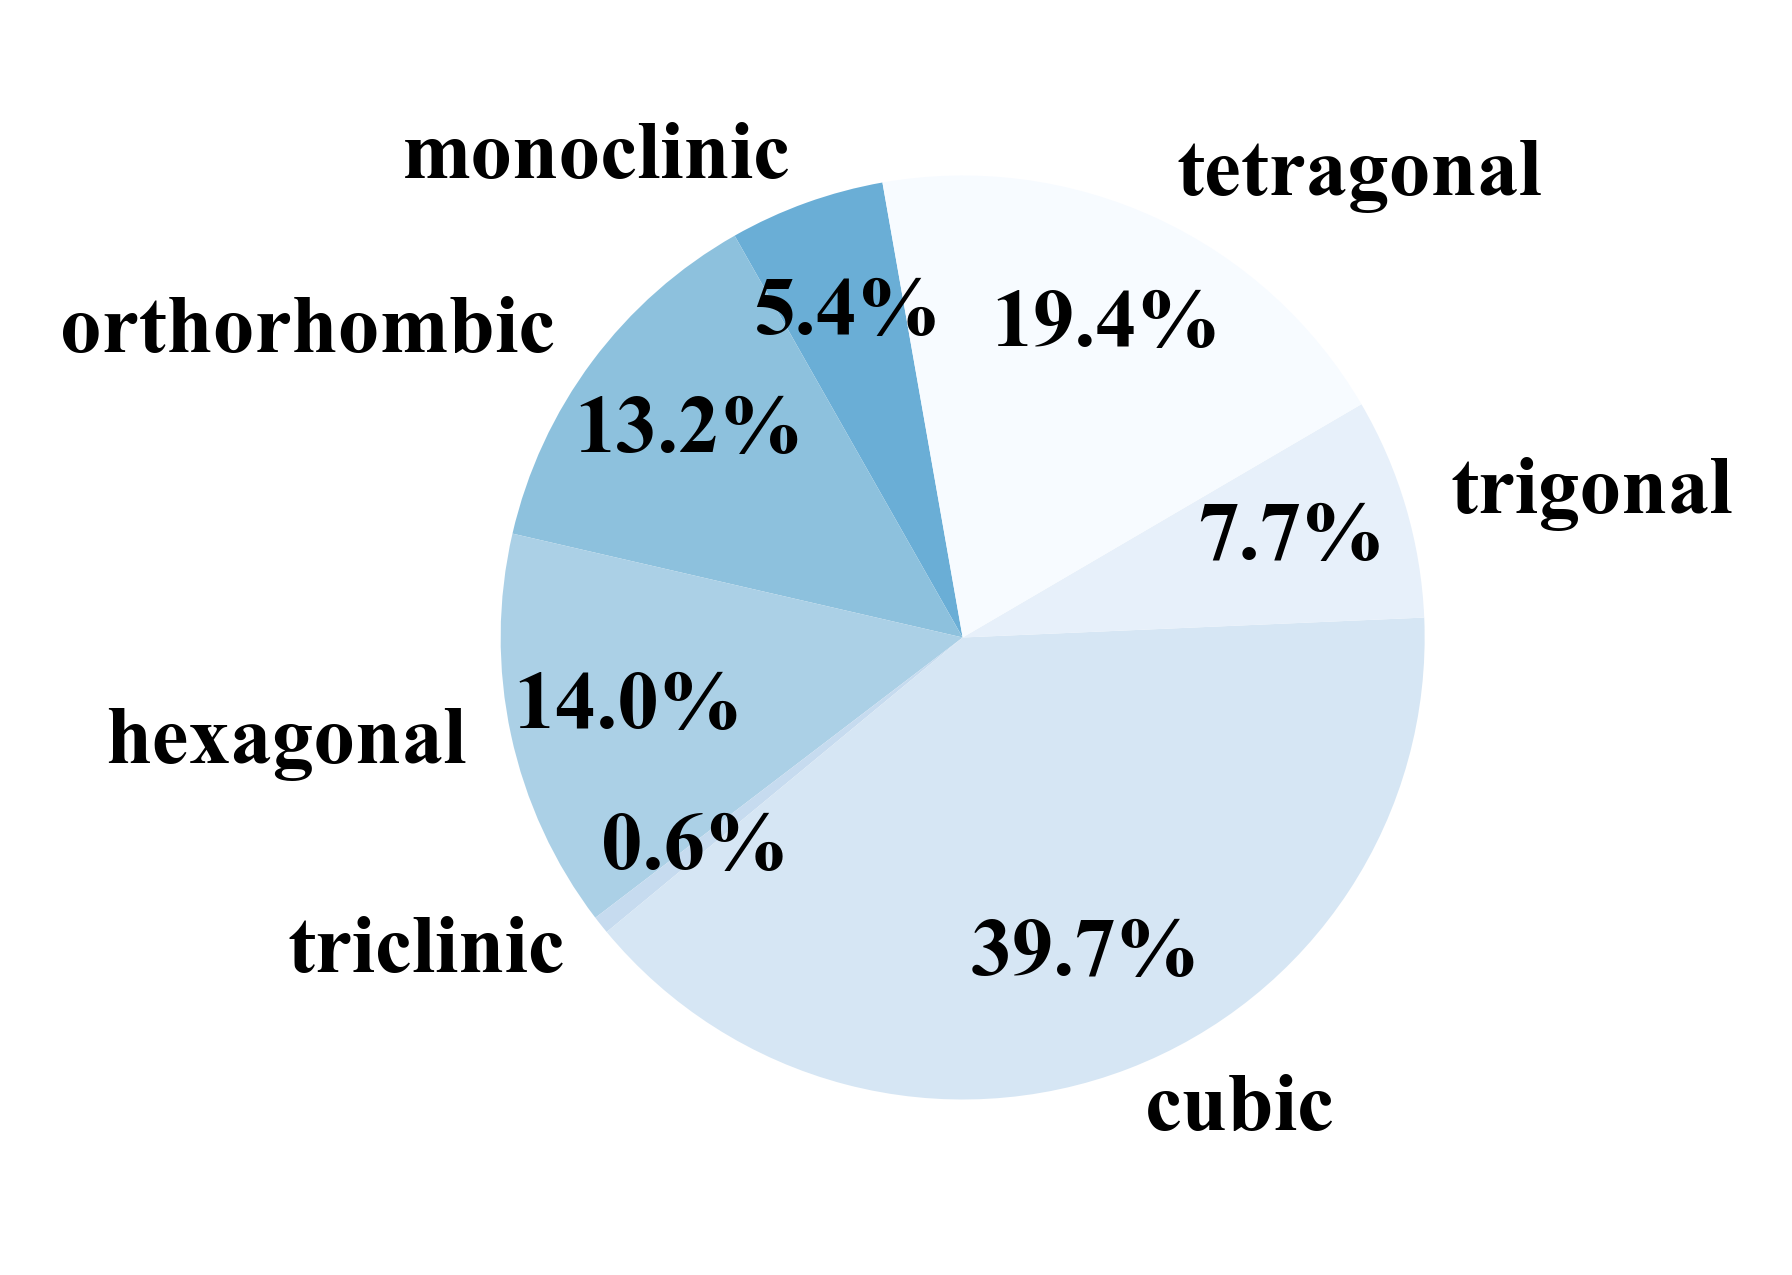

In [35]:
## plotting data distribution of crystal systems
cs_cnt = {'monoclinic': 572, 'orthorhombic': 1386, 'hexagonal': 1471, 'triclinic': 66, 'cubic': 4175, 'trigonal': 814, 'tetragonal': 2036}
labels = list(cs_cnt.keys())
sizes = list(cs_cnt.values())
colors = plt.get_cmap('Blues')(np.linspace(0.5, 0, len(cs_cnt)))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=100, textprops={'size': 10}, labeldistance=1.1, pctdistance=0.74)
plt.savefig('mp_crystal_system_distribution.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

### stability

In [3]:
import numpy as np
import ast
from pymatgen.analysis.elasticity import ElasticTensor
import json

def is_positive_definite(matrix):
    """
    Check if a matrix is positive definite
    
    Args:
        matrix: numpy array, the input matrix to check
        
    Returns:
        bool: True if matrix is positive definite, False otherwise
    """
    try:
        # Check if matrix is symmetric
        if not np.allclose(matrix, matrix.T):
            return False
            
        # Try Cholesky decomposition - only works on positive definite matrices
        np.linalg.cholesky(matrix)
        return True
        
    except np.linalg.LinAlgError:
        return False

# Read the mp_data.jsonl file
with open('mp_data.jsonl', 'r') as file:
    data = [json.loads(line) for line in file]
# Extract values where label == 'test'
test_data = [item for item in data if item.get('label') == 'test']
test_data_tensor_list = [np.array(test_data[i]['elastic_tensor']) for i in range(len(test_data))]
# Check if the tensors are positive definite
positive_definite_count = 0
id_list = []
for i in range(len(test_data_tensor_list)):
    if is_positive_definite(test_data_tensor_list[i]):
        positive_definite_count += 1
        id_list.append(i)
print("test set", positive_definite_count)
print("id list length", len(id_list))

# Read the generated_predictions.jsonl file
with open('../ElaTBoT-DFT/ft_result/prompt4/test_result_repeat_in_bohrium_v100/generated_predictions.jsonl', 'r') as file:
    generated_test_data = [json.loads(line) for line in file]
tensor_list_elatbot = [np.array(ast.literal_eval(generated_test_data[i]['predict'])) for i in range(len(generated_test_data))]
# Check if the tensors are positive definite
positive_definite_count = 0
for i in range(len(tensor_list_elatbot)):
    if i in id_list:
        if is_positive_definite(tensor_list_elatbot[i]):
            positive_definite_count += 1
        else:
            t = np.array(ast.literal_eval(generated_test_data[i]['label']))
            if is_positive_definite(t):
                print("it's positive definite")
print("elatbot-dft:", positive_definite_count)

# matten
matten_predict = np.load("../ElaTBoT-DFT/algorithm_comparison/MatTen_result/elastic_tensors_predicted_test_set.npy")
matten_real = np.load("../ElaTBoT-DFT/algorithm_comparison/MatTen_result/elastic_tensors_real_test_set.npy")
matten_real = [ElasticTensor(i).voigt for i in matten_real]
matten_predict = [ElasticTensor(i).voigt for i in matten_predict]
id_list_matten = []
positive_definite_count_matten = 0
for i in range(len(matten_real)):
    if is_positive_definite(matten_real[i]):
        positive_definite_count_matten += 1
        id_list_matten.append(i)
print("matten-test-set:", positive_definite_count_matten)
# Check if the tensors are positive definite
positive_definite_count_matten = 0
for i in range(len(matten_predict)):
    if i in id_list_matten:
        if is_positive_definite(matten_predict[i]):
            positive_definite_count_matten += 1
print("matten-predicted:", positive_definite_count_matten)

# random forest
rf_test_data = np.load('../ElaTBoT-DFT/algorithm_comparison/random_forest/rf_elastic_tensors_predicted_test_set.npy')
rf_test_data = [np.array(rf_test_data[i].tolist()) for i in range(len(rf_test_data))]
positive_definite_count = 0
for i in range(len(tensor_list_elatbot)):
    if i in id_list:
        if is_positive_definite(tensor_list_elatbot[i]):
            positive_definite_count += 1
print("rf:", positive_definite_count)



test set 519
id list length 519
it's positive definite
elatbot-dft: 518


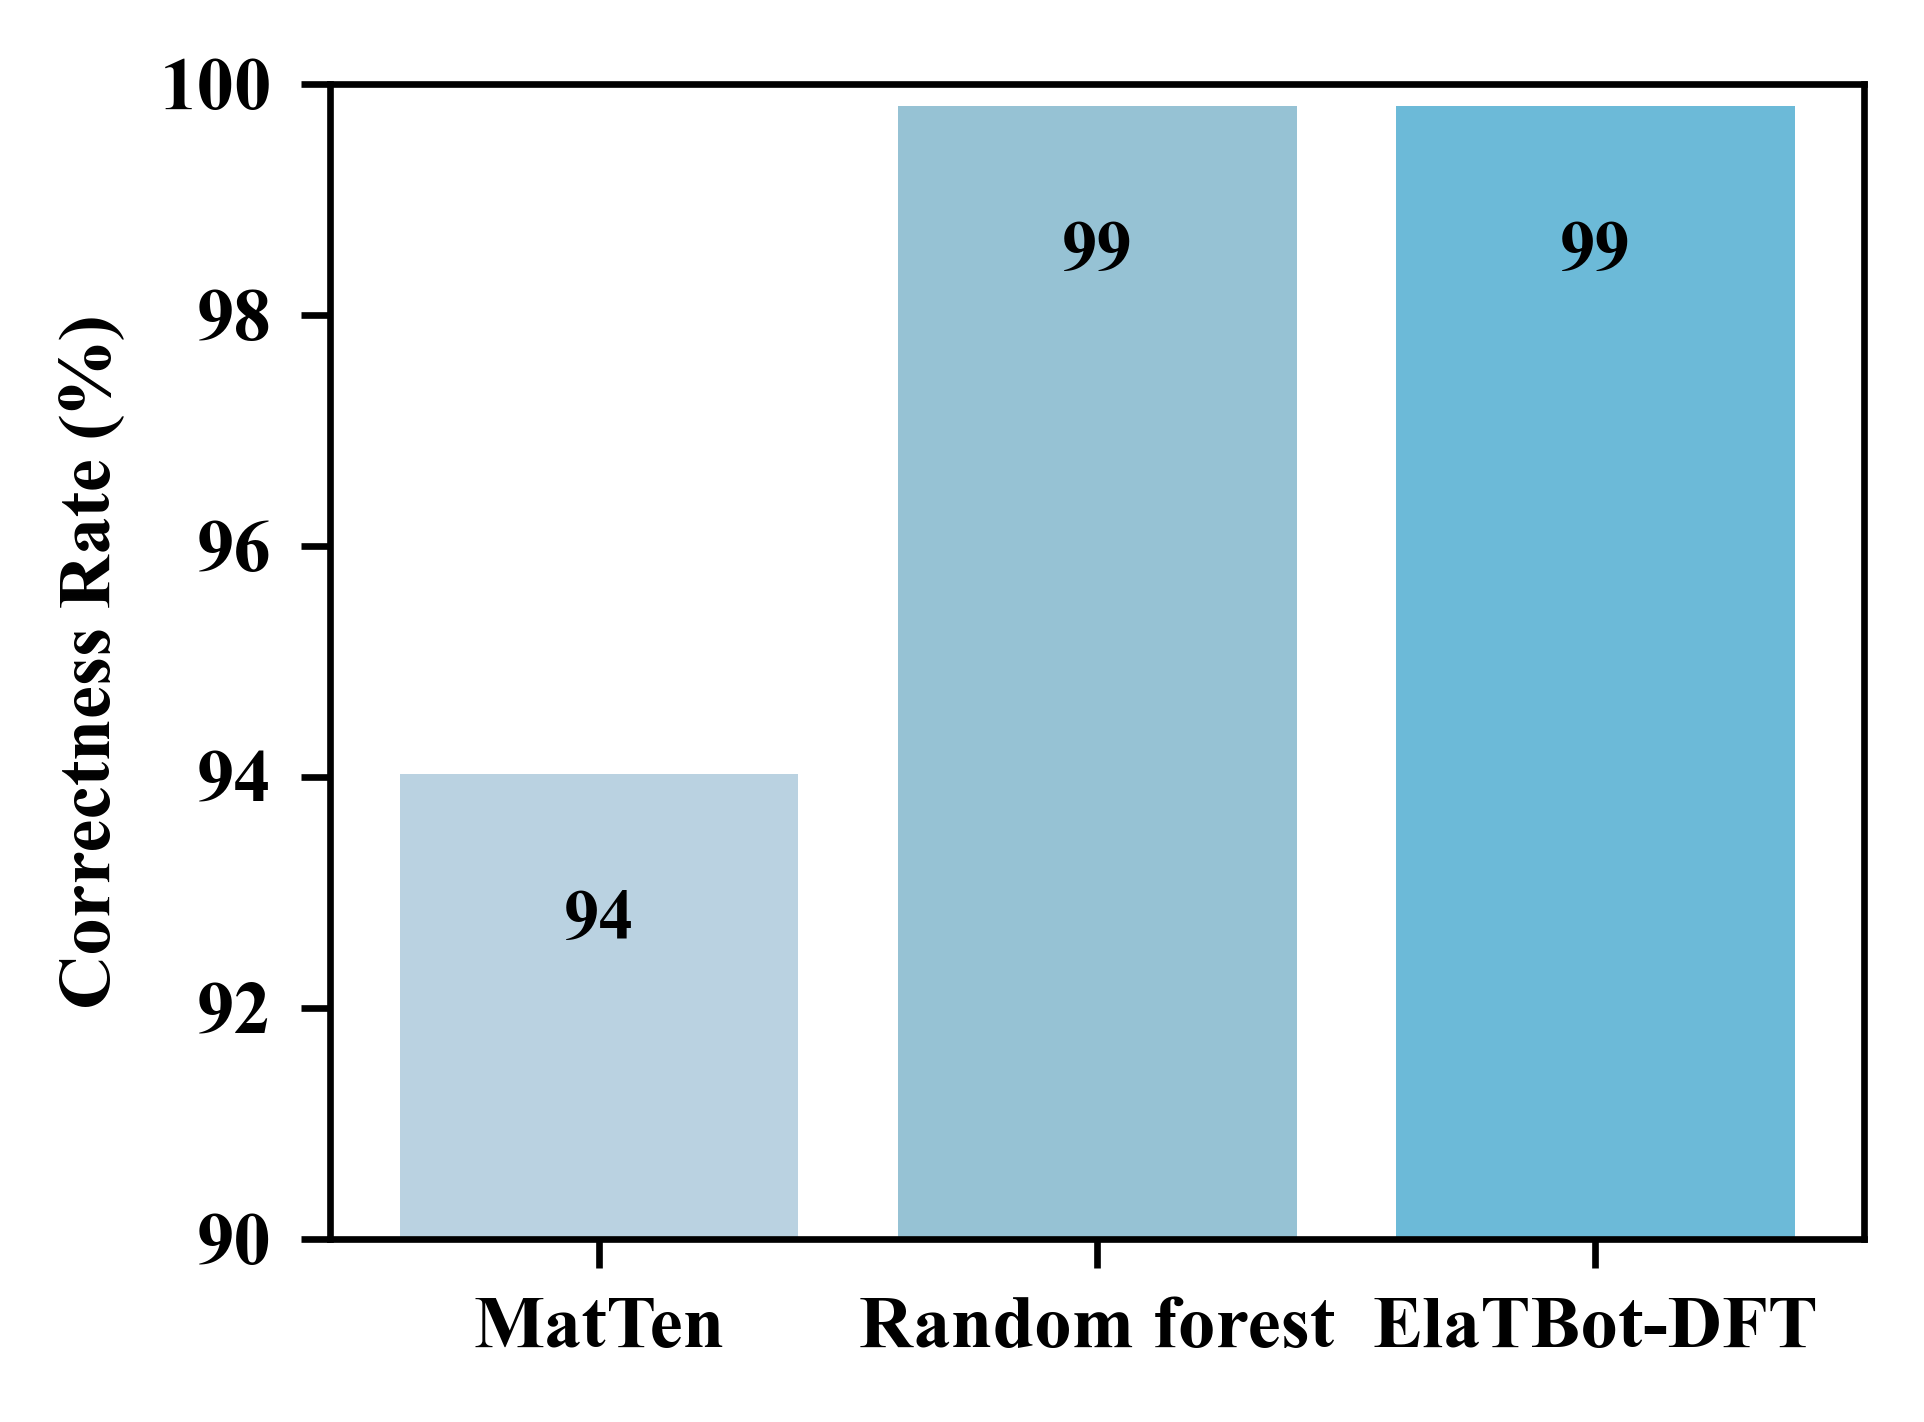

In [4]:
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scienceplots
plt.style.use('ieee')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

label = ['MatTen', 'Random forest', 'ElaTBot-DFT']
accuracy = [94.02,99.81, 99.81]
bars = plt.bar(label, accuracy, color=['#BAD2E1', '#96C2D4', '#6CBAD8'])
plt.ylabel('Correctness Rate (%)', fontsize=9)
plt.ylim(90, 100)

# Adding the accuracy values inside the top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 1, int(yval), 
             ha='center', va='top', fontsize=8.5, color='black')
plt.tick_params(axis='both', labelsize=9)
plt.savefig("stability_check_result.pdf", dpi=600, bbox_inches='tight')
plt.show()